In [1]:
import common
import importlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import socket

# Show all columns and rows in a dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:
# graphalytics inserts
pers_experiments = "num_threads_read == 0 and (hostname == 'scyper22')"

data_ins = common.import_gfe("view_graphalytics_inserts").query(pers_experiments).copy() # data from the experiments
data_ins["build_frequency"].fillna(pd.Timedelta(0), inplace=True) # replace NaT with 0, otherwise the records are ignored in the group by

data_ins = data_ins.query("((block_size == 512) and library == 'sortledton.3') or library != 'sortledton.3'")

# graphalytics load
data_load = common.import_gfe("view_graphalytics_load").query(pers_experiments).copy()
# shape the dataframe as data_ins
data_load["build_frequency"] = pd.Timedelta(0)
data_load["build_frequency_secs"] = np.NaN
data_load["num_snapshots_created"] = 0
data_load["num_threads_write"] = 0
data_load["block_size"] = -1

data = pd.concat([data_ins, data_load])
data["validate_inserts"].fillna("0", inplace=True)
data["validate_output"].fillna("0", inplace=True)


data = data.query("validate_inserts == '0' and validate_output == '0'")

data = data.groupby(["library", "compiler_family", "graph", "build_frequency","num_threads_read", "num_threads_write", "algorithm"]) \
    .agg(completion_time=("median_secs", "median"), count=("median_secs", "count"), ct_std=("median_secs", "std"))
data["cov"] = data["ct_std"] / data["completion_time"]
data

completion_time  \
library                        compiler_family graph          build_frequency num_threads_read num_threads_write algorithm                    
baseline_v3                    gcc             dota-league    0 days 00:00:00 0                1                 bfs               7.538361   
                                                                                                                 cdlp             52.287221   
                                                                                                                 lcc            1882.367861   
                                                                                                                 pagerank         74.906913   
                                                                                                                 sssp              3.600868   
                                                                                                                 wcc              10.388922   
                                               graph500-24    0 days 00:00:00 0                1                 bfs             125.555598   
                                                                                                                 cdlp                   NaN   
                                                                                                                 lcc                    NaN   
                                                                                                                 pagerank       1266.711086   
                                                                                                                 sssp             81.206667   
                                                                                                                 wcc             322.996458   
                                               uniform-24     0 days 00:00:00 0                1                 bfs             153.350156   
                                                                                                                 cdlp           1797.668647   
                                                                                                                 lcc             421.805360   
                                                                                                                 pagerank       1628.261105   
                                                                                                                 sssp            100.996033   
                                                                                                                 wcc             186.280122   
csr3                           gcc             com-friendster 0 days 00:00:00 0                0                 bfs               1.027292   
                                                                                                                 cdlp            160.783570   
                                                                                                                 lcc             835.651810   
                                                                                                                 pagerank         31.602786   
                                                                                                                 sssp             43.221247   
                                                                                                                 wcc              10.248647   
                                               dota-league    0 days 00:00:00 0                0                 bfs               0.000805   
                                                                                                                 cdlp              1.148272   
                                                                                                                 lcc    

In [3]:
data_high_err = data.query("cov > 0.1")
data_high_err

completion_time  \
library                   compiler_family graph          build_frequency num_threads_read num_threads_write algorithm                    
csr3-lcc                  gcc             com-friendster 0 days 00:00:00 0                0                 cdlp            296.952842   
                                                                                                            sssp             53.552172   
                                          graph500-22    0 days 00:00:00 0                0                 sssp              0.901464   
                                          graph500-24    0 days 00:00:00 0                0                 cdlp             32.441325   
                                          graph500-26    0 days 00:00:00 0                0                 cdlp            104.740893   
                                                                                                            sssp             32.456623   
                                          uniform-24     0 days 00:00:00 0                0                 cdlp             24.325043   
                                          uniform-26     0 days 00:00:00 0                0                 cdlp             98.890649   
csr3-lcc-numa             gcc             com-friendster 0 days 00:00:00 0                0                 cdlp            177.237292   
                                                                                                            sssp             59.441738   
                                          dota-league    0 days 00:00:00 0                0                 bfs               0.000727   
                                          graph500-22    0 days 00:00:00 0                0                 cdlp              8.122214   
                                          graph500-24    0 days 00:00:00 0                0                 cdlp             14.926092   
                                          graph500-26    0 days 00:00:00 0                0                 cdlp            140.942144   
                                          uniform-24     0 days 00:00:00 0                0                 cdlp             23.132612   
                                          uniform-26     0 days 00:00:00 0                0                 cdlp            180.167332   
g1_v6-ref-ignore-build    gcc             graph500-22    0 days 00:00:00 0                20                cdlp              9.974392   
                                          graph500-24    0 days 00:00:00 0                20                cdlp             31.449167   
                                          graph500-26    0 days 00:00:00 0                20                bfs               5.189803   
                                                                                                            cdlp            135.322500   
                                          uniform-24     0 days 00:00:00 0                20                cdlp             47.025972   
                                          uniform-26     0 days 00:00:00 0                20                cdlp            186.268955   
                                                                                                            wcc             539.230175   
livegraph3_ro             gcc             com-friendster 0 days 00:00:00 0                20                cdlp            290.855899   
                                          graph500-22    0 days 00:00:00 0                20                cdlp              6.935005   
                                                                                                            wcc               0.390946   
                                          graph500-24    0 days 00:00:00 0                20                cdlp             27.848318   
                                          uniform-24     0 days 00:00:00 0                20                cdlp     

In [4]:
low_count = data.query("count < 5").copy()
low_count = low_count.query("(library == 'llama8-ref' and build_frequency != '00:00:00') or library != 'llama8-ref'")
low_count = low_count.query("num_threads_write == 0 or num_threads_write == 56")
low_count = low_count.query("library != 'sortledton'")
low_count = low_count.query("library != 'sortledton.1'")
low_count

completion_time  \
library                        compiler_family graph          build_frequency num_threads_read num_threads_write algorithm                    
csr3                           gcc             com-friendster 0 days          0                0                 bfs               1.027292   
                                                                                                                 cdlp            160.783570   
                                                                                                                 lcc             835.651810   
                                                                                                                 pagerank         31.602786   
                                                                                                                 sssp             43.221247   
                                                                                                                 wcc              10.248647   
                                               dota-league    0 days          0                0                 bfs               0.000805   
                                                                                                                 cdlp              1.148272   
                                                                                                                 lcc             363.353080   
                                                                                                                 pagerank          0.137712   
                                                                                                                 sssp              0.402430   
                                                                                                                 wcc               0.029459   
                                               graph500-22    0 days          0                0                 bfs               0.036871   
                                                                                                                 cdlp              8.128233   
                                                                                                                 lcc             306.267269   
                                                                                                                 pagerank          0.409062   
                                                                                                                 sssp              0.861648   
                                                                                                                 wcc               0.158084   
                                               graph500-24    0 days          0                0                 bfs               0.137484   
                                                                                                                 cdlp             33.922899   
                                                                                                                 lcc            2236.280409   
                                                                                                                 pagerank          2.724284   
                                                                                                                 sssp              6.828722   
                                                                                                                 wcc               0.939615   
                                               graph500-26    0 days          0                0                 bfs               0.498458   
                                                                                                                 cdlp             70.469243   
                                                                                                                 lcc    

List of available executions:

In [5]:
data = data.unstack("algorithm")[("completion_time")]
data.index.set_names("compiler", level=1, inplace=True)

fn_join_threads = lambda grp: ", ".join(map(str, grp.unique()))
data.reset_index().groupby(["library", "compiler"]).agg(num_threads_w=("num_threads_write", fn_join_threads), num_threads_r=("num_threads_read", fn_join_threads))

,,num_threads_w,num_threads_r
library,compiler,,
baseline_v3,gcc,1,0
csr3,gcc,0,0
csr3-lcc,gcc,0,0
csr3-lcc-numa,gcc,0,0
g1_v6-ref-ignore-build,gcc,20,0
livegraph3_ro,gcc,20,0
llama8-ref,gcc,16,0
mb-csr.6,gcc,56,0
mb-csr.8,gcc,56,0


### CSR

In [6]:
csr = data.loc[("csr3-lcc", "gcc")].droplevel([1,2,3]).rename(columns = {"lcc": "lcc_sorted"})
csr["lcc_std"] = data.loc[("csr3", "gcc")].droplevel([1,2,3]).rename(columns = {"lcc": "lcc_std"})["lcc_std"]
csr_numa = data.loc[("csr3-lcc-numa", "gcc")].droplevel([1,2,3]).rename(columns = {"lcc": "lcc_sorted"})
csr_numa["lcc_std"] = data.loc[("csr3", "gcc")].droplevel([1,2,3]).rename(columns = {"lcc": "lcc_std"})["lcc_std"]
mb_csr = data.loc[("mb-csr.8", "gcc")].droplevel([1,2,3]).rename(columns = {"lcc": "lcc_sorted"})
mb_csr["lcc_std"] = data.loc[("csr3", "gcc")].droplevel([1,2,3]).rename(columns = {"lcc": "lcc_std"})["lcc_std"]
min_csr = mb_csr.combine(csr_numa, np.minimum)
csr = csr[["bfs", "cdlp", "lcc_std", "lcc_sorted", "pagerank", "sssp", "wcc"]] # reoder the columns
csr = pd.concat([csr, csr_numa, mb_csr, min_csr], names=["library"], keys=["csr", "csr_numa", "mb_csr", "min_csr"]) # prepend the key `csr`

min_csr

algorithm,bfs,cdlp,lcc_sorted,pagerank,sssp,wcc,lcc_std
graph,,,,,,,
com-friendster,0.970899,177.237292,59.522565,30.500050,53.355011,10.068403,835.651810
dota-league,0.000727,1.170245,50.710683,0.105036,0.245215,0.023842,363.353080
graph500-22,0.033258,4.863053,8.431614,0.335798,0.739230,0.119485,306.267269
graph500-24,0.131544,14.926092,51.499478,1.772717,4.719282,0.585356,2236.280409
graph500-26,0.480766,119.647970,309.646945,10.626454,26.432848,3.006076,NaN
uniform-24,0.148202,23.132612,2.816906,3.309615,6.443192,1.008911,21.949081
uniform-26,0.518993,132.497073,13.111546,18.350899,34.104711,6.210624,92.364151


In [7]:

mb_csr

algorithm,bfs,cdlp,lcc_sorted,pagerank,sssp,wcc,lcc_std
graph,,,,,,,
com-friendster,1.136903,276.220484,59.522565,30.500050,53.355011,16.644087,835.651810
dota-league,0.000793,1.170245,50.710683,0.140908,0.404502,0.030013,363.353080
graph500-22,0.037948,4.863053,8.431614,0.335798,0.819534,0.119485,306.267269
graph500-24,0.138091,21.144067,51.499478,1.772717,4.719282,0.585356,2236.280409
graph500-26,0.514324,119.647970,309.646945,10.626454,29.054993,3.006076,NaN
uniform-24,0.154155,41.418921,3.232153,3.343949,9.998437,1.008911,21.949081
uniform-26,0.563581,132.497073,14.869173,18.527266,46.767923,7.454135,92.364151


In [8]:
compare = mb_csr / csr_numa
compare


algorithm,bfs,cdlp,lcc_sorted,pagerank,sssp,wcc,lcc_std
graph,,,,,,,
com-friendster,1.170980,1.558478,0.991501,0.976704,0.897602,1.653101,1.0
dota-league,1.090784,0.998819,0.945243,1.341521,1.649581,1.258829,1.0
graph500-22,1.141019,0.598735,0.706678,0.845264,1.108631,0.775558,1.0
graph500-24,1.049767,1.416584,0.714416,0.659427,0.977632,0.630081,1.0
graph500-26,1.069801,0.848915,0.647426,0.699060,1.099200,0.608095,NaN
uniform-24,1.040168,1.790499,1.147412,1.010374,1.551783,0.866354,1.0
uniform-26,1.085913,0.735411,1.134052,1.009611,1.371304,1.200223,1.0


### Other systems

In [9]:
stinger = pd.concat( [
    data.loc[("stinger7-ref", "gcc")].droplevel([1, 2, 3])
], names=["library"], keys=["stinger"])
llama = pd.concat( [
    data.loc[("llama8-ref", "gcc", slice(None), "00:00:10", 0, 16)].droplevel([0, 1, 3, 4, 5]) # dynamic scheduling in OpenMP
], names=["library"], keys=["llama"] )
graphone = pd.concat( [
   data.loc[("g1_v6-ref-ignore-build", "gcc", slice(None), slice(None), 0, 20)].droplevel([0, 1, 3, 4, 5])
], names=["library"], keys=["graphone"] )
livegraph = pd.concat( [
    data.loc[("livegraph3_ro", "gcc", slice(None), slice(None), slice(None), 20)].droplevel([0, 1, 3, 4, 5])
], names=["library"], keys=["livegraph"] )
competitors = pd.concat([stinger,llama,graphone, livegraph]).rename(columns = {"lcc": "lcc_std"})
#competitors = pd.concat([stinger]).rename(columns = {"lcc": "lcc_std"})
competitors["lcc_sorted"] = np.NaN

### Teseo

In [10]:
teseo_lcc = data.loc[("teseo-lcc.12", "gcc")].droplevel([1,2,3]).rename(columns={"lcc": "lcc_sorted"})
teseo_dv_lcc = data.loc[("teseo-lcc-dv.12b", "gcc")].droplevel([1,2,3]).rename(columns={"lcc": "lcc_sorted"})
teseo_lcc["lcc_std"] = np.NaN
teseo_dv_lcc["lcc_std"] = np.NaN

#teseo_std = data.loc[("teseo.12", "gcc")].droplevel([1,2,3]).rename(columns={"lcc": "lcc_std"})
#teseo_std_dv = data.loc[("teseo-dv.12b", "gcc")].droplevel([1,2,3]).rename(columns={"lcc": "lcc_std"})
teseo_logical = pd.concat([ pd.concat([teseo_lcc], axis=1 ) ], names=["library"], keys=["teseo_logical"])
teseo_real = pd.concat([ pd.concat([teseo_dv_lcc], axis=1 ) ], names=["library"], keys=["teseo_real"])

### Sortledton

In [11]:
sortledton3 = data.loc[("sortledton.3", "gcc")].droplevel([1,2,3]).rename(columns={"lcc": "lcc_sorted"})
sortledton2 = data.loc[("sortledton.2", "gcc")].droplevel([1,2,3]).rename(columns={"lcc": "lcc_sorted"})
sortledton1 = data.loc[("sortledton.1", "gcc")].droplevel([1,2,3]).rename(columns={"lcc": "lcc_sorted"})

sortledton = pd.concat([ pd.concat([sortledton3], axis=1 ) ], names=["library"], keys=["sortledton"])
sortledton

algorithm                       bfs        cdlp  lcc_sorted   pagerank  \
library    graph                                                         
sortledton com-friendster  5.027893  238.939591   63.483339  34.751672   
           dota-league     0.001097    1.219088   49.638318   0.128635   
           graph500-22     0.045300    7.430630    8.368674   0.450562   
           graph500-24     0.161217   28.082188   47.923769   2.233610   
           graph500-26     0.601730  133.241503  278.601516  11.863777   
           uniform-24      0.170649   35.626129    3.752576   4.015327   
           uniform-26      0.634064  178.967329   15.940698  20.745641   

algorithm                       sssp        wcc  
library    graph                                 
sortledton com-friendster  50.344591  17.152766  
           dota-league      0.274610   0.027313  
           graph500-22      0.836904   0.140162  
           graph500-24      3.797645   0.632409  
           graph500-26     24.081992   3.098358  
           uniform-24       8.175456   1.049245  
           uniform-26      43.973580   6.888502

In [12]:
sortledton3

algorithm,bfs,cdlp,lcc_sorted,pagerank,sssp,wcc
graph,,,,,,
com-friendster,5.027893,238.939591,63.483339,34.751672,50.344591,17.152766
dota-league,0.001097,1.219088,49.638318,0.128635,0.274610,0.027313
graph500-22,0.045300,7.430630,8.368674,0.450562,0.836904,0.140162
graph500-24,0.161217,28.082188,47.923769,2.233610,3.797645,0.632409
graph500-26,0.601730,133.241503,278.601516,11.863777,24.081992,3.098358
uniform-24,0.170649,35.626129,3.752576,4.015327,8.175456,1.049245
uniform-26,0.634064,178.967329,15.940698,20.745641,43.973580,6.888502


In [13]:
sortledton1

algorithm,bfs,cdlp,lcc_sorted,pagerank,sssp,wcc
graph,,,,,,
com-friendster,3.235775,321.215246,134.895574,34.986696,69.481733,17.536508
dota-league,0.003482,1.240770,452.727168,0.128084,0.438770,0.027536
graph500-22,0.104128,5.123496,45.341988,0.444678,1.442452,0.137924
graph500-24,0.411168,32.897589,223.036627,2.253371,6.687490,0.642449
graph500-26,1.518767,146.673093,1257.411068,11.865370,39.225274,3.105267
uniform-24,0.423987,41.752513,5.013913,4.055012,11.751173,1.058800
uniform-26,1.546263,148.820877,22.097930,20.850237,57.944908,8.048062


I verified that this data is not signficantly different from Sortledton.0

Sortledton.2 vs Sortledton.1

LCC is now much faster, mostly due to the use of shared locks. SSSP is a good bit faster due to the use of blocked iterators.
Pagerank and CDLP show little difference. 
BFS shows little difference, although I tried the same optimizations which put it at one level with a CSR in the microbenchmarks.

I investigate the issue. First, I removed locking from the computation. This did not change anything. I also moved BFS to run after PageRank. No change.

### Dataset

In [14]:
ds = pd.concat([csr, competitors, teseo_logical, teseo_real, sortledton])
ds = pd.concat([ds, pd.concat([ds.query("library != 'min_csr' and library != 'mb_csr' and library != 'csr' and library != 'csr_numa'").groupby(by="graph", axis=0).apply(lambda t: t.min())], names=["library"], keys=["best_excl_csr"])])
ds

algorithm                          bfs        cdlp      lcc_std  lcc_sorted  \
library       graph                                                           
csr           com-friendster  0.987290  296.952842   835.651810   67.071760   
              dota-league     0.000832    1.130815   363.353080   54.222333   
              graph500-22     0.034255    8.039117   306.267269   12.347005   
              graph500-24     0.136920   32.441325  2236.280409   80.472171   
              graph500-26     0.501221  104.740893          NaN  569.605217   
              uniform-24      0.145892   24.325043    21.949081    2.925042   
              uniform-26      0.566363   98.890649    92.364151   13.866267   
csr_numa      com-friendster  0.970899  177.237292   835.651810   60.032766   
              dota-league     0.000727    1.171629   363.353080   53.648330   
              graph500-22     0.033258    8.122214   306.267269   11.931342   
              graph500-24     0.131544   14.926092  2236.280409   72.086112   
              graph500-26     0.480766  140.942144          NaN  478.273912   
              uniform-24      0.148202   23.132612    21.949081    2.816906   
              uniform-26      0.518993  180.167332    92.364151   13.111546   
mb_csr        com-friendster  1.136903  276.220484   835.651810   59.522565   
              dota-league     0.000793    1.170245   363.353080   50.710683   
              graph500-22     0.037948    4.863053   306.267269    8.431614   
              graph500-24     0.138091   21.144067  2236.280409   51.499478   
              graph500-26     0.514324  119.647970          NaN  309.646945   
              uniform-24      0.154155   41.418921    21.949081    3.232153   
              uniform-26      0.563581  132.497073    92.364151   14.869173   
min_csr       com-friendster  0.970899  177.237292   835.651810   59.522565   
              dota-league     0.000727    1.170245   363.353080   50.710683   
              graph500-22     0.033258    4.863053   306.267269    8.431614   
              graph500-24     0.131544   14.926092  2236.280409   51.499478   
              graph500-26     0.480766  119.647970          NaN  309.646945   
              uniform-24      0.148202   23.132612    21.949081    2.816906   
              uniform-26      0.518993  132.497073    92.364151   13.111546   
stinger       dota-league     0.121506    1.538311  1029.737622         NaN   
              graph500-22     0.138942    4.151513   896.330526         NaN   
              graph500-24     0.509728   19.405766          NaN         NaN   
              uniform-24      0.282872   25.052541    52.990104         NaN   
llama         dota-league     0.002966    2.401328          NaN         NaN   
              graph500-22     0.044881    8.249646          NaN         NaN   
              graph500-24     0.165804   30.885655          NaN         NaN   
              uniform-24      0.212838   63.223419          NaN         NaN   
graphone      dota-league     3.315888    4.690717   556.099816         NaN   
              graph500-22     3.372719    9.974392   484.695291         NaN   
              graph500-24     3.666789   31.449167          NaN         NaN   
              graph500-26     5.189803  135.322500          NaN         NaN   
              uniform-24      3.728817   47.025972    72.123853         NaN   
              uniform-26      5.263770  186.268955   338.458564         NaN   
livegraph     com-friendster  8.524041  290.855899  1428.454927         NaN   
              dota-league     0.057192    1.395516   573.513740         NaN   
              graph500-22     0.519948    6.935005   493.041368         NaN   
              graph500-24     2.150392   27.848318          NaN         NaN   
              graph500-26     8.921137  115.255477          NaN         NaN   
              uniform-24      0.804347   42.654666    38.357464         NaN   
              uniform-26      3.155160  174.584802

## Show Speedups

In [15]:
speedups = ds.copy()

csr_name = "min_csr"

speedups["bfs_speedup"] = speedups["bfs"] / speedups.loc[csr_name]["bfs"]
speedups["cdlp_speedup"] = speedups["cdlp"] / speedups.loc[csr_name]["cdlp"]
speedups["lcc_std_speedup"] = speedups["lcc_std"] / speedups.loc[csr_name]["lcc_std"]
speedups["lcc_sorted_speedup"] = speedups["lcc_sorted"] / speedups.loc[csr_name]["lcc_sorted"]
speedups["pagerank_speedup"] = speedups["pagerank"] / speedups.loc[csr_name]["pagerank"]
speedups["sssp_speedup"] = speedups["sssp"] / speedups.loc[csr_name]["sssp"]
speedups["wcc_speedup"] = speedups["wcc"] / speedups.loc[csr_name]["wcc"]



speedups.drop(["bfs", "cdlp", "lcc_std", "lcc_sorted", "pagerank", "sssp", "wcc"], axis=1, inplace=True)
speedups

algorithm                     bfs_speedup  cdlp_speedup  lcc_std_speedup  \
library       graph                                                        
csr           com-friendster     1.016882      1.675454         1.000000   
              dota-league        1.144429      0.966306         1.000000   
              graph500-22        1.029978      1.653101         1.000000   
              graph500-24        1.040868      2.173464         1.000000   
              graph500-26        1.042547      0.875409              NaN   
              uniform-24         0.984413      1.051548         1.000000   
              uniform-26         1.091273      0.746361         1.000000   
csr_numa      com-friendster     1.000000      1.000000         1.000000   
              dota-league        1.000000      1.001183         1.000000   
              graph500-22        1.000000      1.670188         1.000000   
              graph500-24        1.000000      1.000000         1.000000   
              graph500-26        1.000000      1.177974              NaN   
              uniform-24         1.000000      1.000000         1.000000   
              uniform-26         1.000000      1.359783         1.000000   
mb_csr        com-friendster     1.170980      1.558478         1.000000   
              dota-league        1.090784      1.000000         1.000000   
              graph500-22        1.141019      1.000000         1.000000   
              graph500-24        1.049767      1.416584         1.000000   
              graph500-26        1.069801      1.000000              NaN   
              uniform-24         1.040168      1.790499         1.000000   
              uniform-26         1.085913      1.000000         1.000000   
min_csr       com-friendster     1.000000      1.000000         1.000000   
              dota-league        1.000000      1.000000         1.000000   
              graph500-22        1.000000      1.000000         1.000000   
              graph500-24        1.000000      1.000000         1.000000   
              graph500-26        1.000000      1.000000              NaN   
              uniform-24         1.000000      1.000000         1.000000   
              uniform-26         1.000000      1.000000         1.000000   
stinger       dota-league      167.133425      1.314520         2.833986   
              graph500-22        4.177702      0.853685         2.926629   
              graph500-24        3.874962      1.300124              NaN   
              uniform-24         1.908692      1.082997         2.414229   
llama         dota-league        4.079092      2.051987              NaN   
              graph500-22        1.349480      1.696393              NaN   
              graph500-24        1.260445      2.069239              NaN   
              uniform-24         1.436134      2.733086              NaN   
graphone      dota-league     4561.056396      4.008320         1.530467   
              graph500-22      101.410758      2.051056         1.582589   
              graph500-24       27.875000      2.106993              NaN   
              graph500-26       10.794863      1.131005              NaN   
              uniform-24        25.160369      2.032886         3.285962   
              uniform-26        10.142276      1.405834         3.664393   
livegraph     com-friendster     8.779534      1.641054         1.709390   
              dota-league       78.668501      1.192499         1.578392   
              graph500-22       15.633772      1.426060         1.609840   
              graph500-24       16.347321      1.865747              NaN   
              graph500-26       18.556090      0.963288              NaN   
              uniform-24         5.427369      1.843919         1.747566   
              uniform-26         6.079388      1.317650         1.799990   
teseo_logical com-friendster     1.479420      2.335253              NaN   
              dota-league       14.557084      1

## We summarize the data

There is nothing too exciting in uniform graphs. We drop them.

We check per dataset if the graph500 scale factor makes a huge difference.

* Livegraph: no
* Stinger: no but we cannot load grah500-26 and timeout for LCC on 24
* Graphone: BFS, Pagerank and WCC see less slowdown for big graph datasets
* Sortledton: we see varying speedup for CDLP and SSSP. A slight tedence to less slowdown on bigger graphs
* Teseo: lcc, pagerank and wcc are much worse for scale factor 24
* Teseor real: Tendence to less slow down on bigger graphs
* LLama: no difference

Generally, slow down improves for bigger scale factors. Teseo has a weak spot for scale factor 24.

We remove Graph500-22.

We now compare Friendster with Graph500-26 for each system:

* Sortledton has issues with BFS on friendster
* Teseo logical: wcc, pagerank and sssp have larger slow downs on graph500-26
* Teseo real: we do not have data for friendster yet
* Livegraph: better slow downs on Friendster for all algorithms, most prounounced for BFS
* Graphone: cannot load friendster
* Llama: cannot load either
* Stinger: cannot load either graph

We drop Graph500-26, because there is nothing new to learn over Graph500-24 if Friendster is presented.

We have three graphs to present dota, friendster and graph500-24.
These represent three different sizes, real and generated graphs, weak points of Sorltedton and Teseo.

We compare LCC in a different setting as there are two different algorithms making the biggest difference.

We drop the BFS speedup as it is extreme for many systems accross various graphs. We compare this in another graph.

We compare all systems on the three graphs. 
We drop Graphone from the barchar because with it nothing can be seen, it is too slow. This is due to its access by copying into a vector.
We drop Stinger and Dota league.

We reconsider and show only Graph500-24. We set an ylimit of 8 to cut out WCC on Graphone.




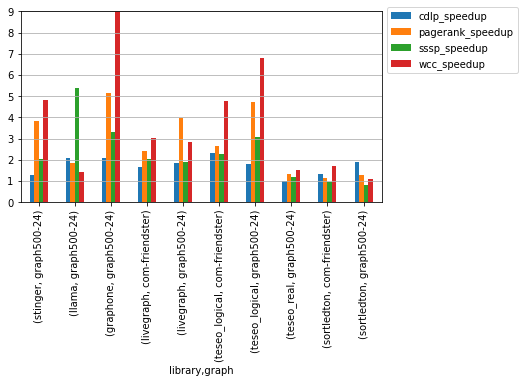

In [36]:
v = speedups
v = v.query("graph in ['graph500-24', 'com-friendster']")
v = v.query("library in ['graphone','sortledton', 'llama', 'teseo_logical', 'teseo_real', 'stinger', 'livegraph']")
v = v.drop("bfs_speedup", axis=1)
#v = v.query("not (library=='graphone' and graph== 'dota-league')")
#v = v.query("not (library=='stinger' and graph=='dota-league')")
v = v.drop("lcc_std_speedup", axis=1)
#v = v.drop("wcc_speedup", axis=1)
v = v.drop("lcc_sorted_speedup", axis=1)



#v= v.drop(["bfs_speedup", "wcc_speedup"], axis =1)
p=v.plot.bar()
p.legend(bbox_to_anchor=(1.0, 1.05))
p.grid(axis="y")
p.set_ylim(0, 9)
fig = plt.gcf()
fig.set_size_inches(5.5, 5.5)
plt.tight_layout()
plt.savefig("/home/per/workspace/sortledton/src/figures/graphalytics-general.png")

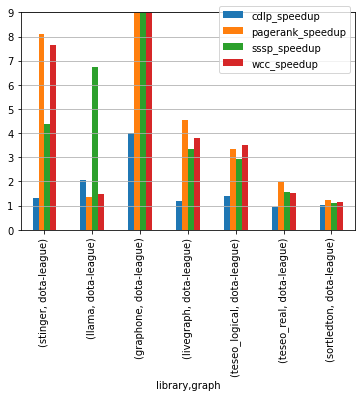

In [17]:
v = speedups
v = v.query("graph in ['dota-league']")
v = v.query("library in ['graphone','sortledton', 'llama', 'teseo_logical', 'teseo_real', 'stinger', 'livegraph']")
v = v.drop("bfs_speedup", axis=1)
#v = v.query("not (library=='graphone' and graph== 'dota-league')")
#v = v.query("not (library=='stinger' and graph=='dota-league')")
v = v.drop("lcc_std_speedup", axis=1)
#v = v.drop("wcc_speedup", axis=1)
v = v.drop("lcc_sorted_speedup", axis=1)



#v= v.drop(["bfs_speedup", "wcc_speedup"], axis =1)
p=v.plot.bar()
p.legend(bbox_to_anchor=(1.0, 1.05))
p.grid(axis="y")
p.set_ylim(0, 9)
plt.savefig("/home/per/workspace/sortledton/src/figures/graphalytics-general-dota-league.png")

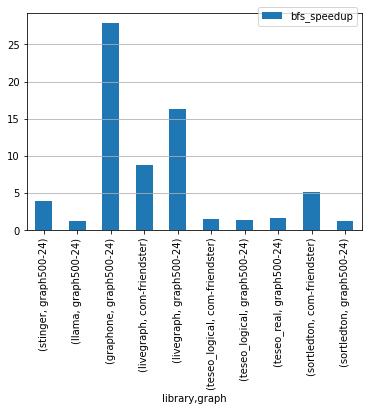

In [18]:
v = speedups
v = v.query("graph in ['graph500-24', 'com-friendster']")
v = v.query("library in ['graphone', 'sortledton', 'llama', 'teseo_logical', 'teseo_real', 'stinger', 'livegraph']")
#v = v.drop("bfs_speedup", axis=1)
#v = v.query("not (library=='graphone' and graph== 'dota-league')")
#v = v.query("not (library=='stinger' and graph=='dota-league')")
v = v.drop(["lcc_std_speedup", "pagerank_speedup", "sssp_speedup", "wcc_speedup", "cdlp_speedup"], axis=1)
v = v.drop("lcc_sorted_speedup", axis=1)

#v= v.drop(["bfs_speedup", "wcc_speedup"], axis =1)
p=v.plot.bar()
p.legend(bbox_to_anchor=(1.0, 1.05))
p.grid(axis="y")
plt.savefig("/home/per/workspace/sortledton/src/figures/graphalytics-bfs.png")

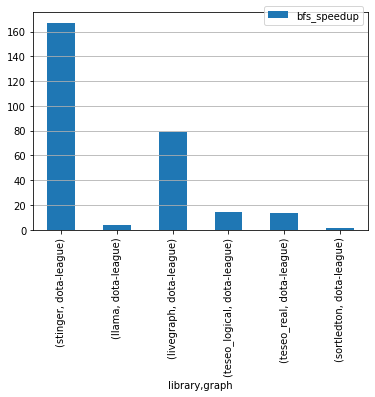

In [19]:
#Cannot include graph one it has a crazy slow down
v = speedups
v = v.query("graph in ['dota-league']")
v = v.query("library in ['sortledton', 'llama', 'teseo_logical', 'teseo_real', 'stinger', 'livegraph']")
#v = v.drop("bfs_speedup", axis=1)
#v = v.query("not (library=='graphone' and graph== 'dota-league')")
#v = v.query("not (library=='stinger' and graph=='dota-league')")
v = v.drop(["lcc_std_speedup", "pagerank_speedup", "sssp_speedup", "wcc_speedup", "cdlp_speedup"], axis=1)
v = v.drop("lcc_sorted_speedup", axis=1)

#v= v.drop(["bfs_speedup", "wcc_speedup"], axis =1)
p=v.plot.bar()
p.legend(bbox_to_anchor=(1.0, 1.05))
p.grid(axis="y")
plt.savefig("/home/per/workspace/sortledton/src/figures/graphalytics-bfs-dota-league.png")

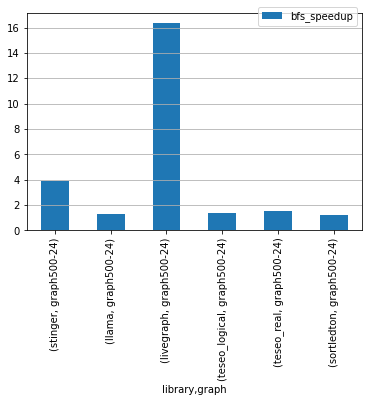

In [20]:
#Cannot include graph one it has a crazy slow down
v = speedups
v = v.query("graph in ['graph500-24']")
v = v.query("library in ['sortledton', 'llama', 'teseo_logical', 'teseo_real', 'stinger', 'livegraph']")
#v = v.drop("bfs_speedup", axis=1)
#v = v.query("not (library=='graphone' and graph== 'dota-league')")
#v = v.query("not (library=='stinger' and graph=='dota-league')")
v = v.drop(["lcc_std_speedup", "pagerank_speedup", "sssp_speedup", "wcc_speedup", "cdlp_speedup"], axis=1)
v = v.drop("lcc_sorted_speedup", axis=1)

#v= v.drop(["bfs_speedup", "wcc_speedup"], axis =1)
p=v.plot.bar()
p.legend(bbox_to_anchor=(1.0, 1.05))
p.grid(axis="y")

### Create the output file

In [21]:
path = os.environ["HOME"] + "/workspace/sortledton/src/tables/analytics_speedup.tex"

In [22]:
def fmtsecs(value):
    if(value >= 20):
        return "{} s".format(int(value))
    else:
        return "{:.2f} s".format(value)

In [23]:
f = open(path, "w")
f.write(r"""
% This file was autogenerated by the script graphalytics_gen_table.ipynb

\resizebox{\textwidth}{!}{ % the table should use 100% of the available width
    \begin{tabular}[t]{clccccccc|clcccccccc}
    \toprule
        Graph  & System            & BFS       & CDLP       & LCC         & LCC (opt)   & PageRank     & SSSP        & WCC             
      & Graph  & System            & BFS       & CDLP       & LCC         & LCC (opt)   & PageRank     & SSSP        & WCC  \\   
    \midrule
""")

def write_csr(graph0, graph1, name0, name1, num_libraries):
    # first graph
    f.write("\\parbox[t]{2mm}{\\multirow{%s}{*}{\\rotatebox[origin=c]{90}{%s}}} & %% %s \n" % (num_libraries, name0, graph0)) 
    f.write("CSR (baseline) ")
    
    if True:
        d0 = ds.loc[("csr_numa", graph0)]
        for c in d0: 
            if np.isnan(c):
                f.write("& DNF")
            else:   
                f.write("& $%s$ " % (fmtsecs(c)))
        f.write(" &\n")
    else:
        f.write(" & & & & & & & &")
        
    # second graph
    f.write("\\parbox[t]{2mm}{\\multirow{%s}{*}{\\rotatebox[origin=c]{90}{%s}}} & %% %s \n" % (num_libraries, name1, graph1)) 
    f.write("CSR (baseline) ") # without &
    d0 = ds.loc[("csr_numa", graph1)]
    for c in d0: 
        if np.isnan(c):
            f.write("& DNF")
        else:       
            f.write("& $%s$ " % (fmtsecs(c)))
    f.write("\\\\\n")
    
def write_speedup_single0(library, graph):
    if True:
        completionTime = ds.loc[(library, graph)]
        speedup = completionTime  / ds.loc[("min_csr", graph)] 
        for column in speedup.index:
            f.write(" & ")
            value = speedup[column]
            best = ds.loc[("best_excl_csr", graph), column]
            if(np.isnan(value)):
                if column == "lcc_std" and (library == "sortledton" or library.startswith("teseo")):
                    f.write("N/A")
                elif column == "lcc_sorted" and not (library == "sortledton" or library.startswith("teseo")):
                    f.write("N/A")
                else:
                    f.write("DNF")
            elif completionTime[column] <= best:
                f.write("$\winner{");
                f.write("{:.2f}x".format(value))
                f.write("}$")
            else:
                f.write("${:.2f}x$".format(value))
    else:
        f.write(" & & & & & & & ")

def write_speedup_single(label, library, graph0, graph1):
    f.write(" & " + label)
    write_speedup_single0(library, graph0)
    f.write(" & & " + label)
    write_speedup_single0(library, graph1)
    f.write(" \\\\ \n")
    
def write_speedup(graph0, graph1, include_llama = True, include_stinger = True, include_graphone=True):
    if (include_stinger): write_speedup_single("Stinger", "stinger", graph0, graph1)
    if(include_llama): write_speedup_single("LLAMA", "llama", graph0, graph1)
    if (include_graphone): write_speedup_single("GraphOne", "graphone", graph0, graph1)
    write_speedup_single("LiveGraph", "livegraph", graph0, graph1)
    write_speedup_single("Teseo, log. vtx", "teseo_logical", graph0, graph1)
    if (graph0 != "com-friendster"): write_speedup_single("Teseo, real vtx", "teseo_real", graph0, graph1)
    write_speedup_single("Sortledton", "sortledton", graph0, graph1)
    
write_csr("dota-league", "graph500-24", "DOTA League", "Graph500 SF 24", 7)
write_speedup("dota-league", "graph500-22")
f.write("\\midrule \n")
write_csr("com-friendster", "graph500-26", "Friendster", "Graph500 SF 26", 7)
write_speedup("com-friendster", "graph500-26", include_llama=False, include_stinger=False, include_graphone=False)
    
f.write(r"""
        \bottomrule
    \end{tabular}
} % end fo resizebox
""")
f.close()